In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/workshop/customer segmentation/

/content/drive/MyDrive/workshop/customer segmentation


In [ ]:
# Reading the csv file
data = pd.read_csv('./Pakistan Largest Ecommerce Dataset.csv')
df = data.copy()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (1,2,3,7,8,9,11,12,13,14,17,18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Step 1: Data Pre-processing

In [ ]:
df.head(3)

,item_id,status,created_at,sku,price,qty_ordered,grand_total,increment_id,category_name_1,sales_commission_code,...,Month,Customer Since,M-Y,FY,Customer ID,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25
0,211131.0,complete,7/1/2016,kreations_YI 06-L,1950.0,1.0,1950.0,100147443,Women's Fashion,\N,...,7.0,2016-7,7-2016,FY17,1.0,NaN,NaN,NaN,NaN,NaN
1,211133.0,canceled,7/1/2016,kcc_Buy 2 Frey Air Freshener & Get 1 Kasual Bo...,240.0,1.0,240.0,100147444,Beauty & Grooming,\N,...,7.0,2016-7,7-2016,FY17,2.0,NaN,NaN,NaN,NaN,NaN
2,211134.0,canceled,7/1/2016,Ego_UP0017-999-MR0,2450.0,1.0,2450.0,100147445,Women's Fashion,\N,...,7.0,2016-7,7-2016,FY17,3.0,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 26 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   item_id                584524 non-null  float64
 1   status                 584509 non-null  object 
 2   created_at             584524 non-null  object 
 3   sku                    584504 non-null  object 
 4   price                  584524 non-null  float64
 5   qty_ordered            584524 non-null  float64
 6   grand_total            584524 non-null  float64
 7   increment_id           584524 non-null  object 
 8   category_name_1        584360 non-null  object 
 9   sales_commission_code  447349 non-null  object 
 10  discount_amount        584524 non-null  float64
 11  payment_method         584524 non-null  object 
 12  Working Date           584524 non-null  object 
 13  BI Status              584524 non-null  object 
 14   MV                    584524 non-

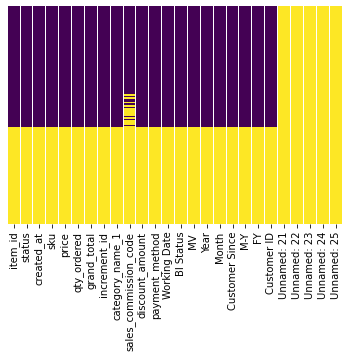

In [ ]:
# Doing a visual inspection of all columns
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

##### Observations
- Out of 26 columns, last 5 columns in the dataset contain NaN values for all records
- Records at 464051 indices (from the bottom) contain NaN values for all columns
- ' MV ' is an ambiguous column name with extra spaces
- Some of the columns have incorrect data types

##### Actions
- Last 5 columns need to be dropped from the dataset
- 464051 rows, containing NaN values need to be dropped from the dataset
- Renamed the columns ' MV ' and 'category_name_1' to 'MV' and 'category_name'

In [ ]:
df.drop(["Unnamed: 21", "Unnamed: 22", "Unnamed: 23", "Unnamed: 24", "Unnamed: 25"], axis = 1, inplace=True)
df.dropna(subset=["item_id"], axis=0, inplace=True)
df.rename(columns={" MV ": "MV", "category_name_1": "category_name"}, inplace = True)

##### Dropping duplicate entries, if any, from the dataset

In [ ]:
df=df.drop_duplicates()

##### Basic data quality and integrity checks

In [ ]:
print("The number of rows with negative or zero Quantity:",sum(n <= 0 for n in df.qty_ordered))
print("The number of rows with negative Price:",sum(n < 0 for n in df.price))

The number of rows with negative or zero Quantity: 0
The number of rows with negative Price: 0


##### Convert all values in 'sku' column to upper case for uniformity

In [ ]:
df['sku']=df['sku'].str.upper()

#### Exploring all columns, finding and Imputing Null Values
#### Categorical Variables

In [ ]:
df['status'].value_counts()

complete          233685
canceled          201249
received           77290
order_refunded     59529
refund              8050
cod                 2859
paid                1159
closed               494
payment_review        57
pending               48
processing            33
holded                31
fraud                 10
pending_paypal         7
exchange               4
\N                     4
Name: status, dtype: int64

##### Observations
- There are a lot of labels for 'status' column.
- Need to check if any relationship exists between 'status' and 'BI Status' columns

In [ ]:
df.groupby('BI Status')['status'].value_counts()

BI Status  status        
#REF!      complete               1
Gross      canceled          201249
           payment_review        57
           pending               48
           processing            33
           holded                31
           fraud                 10
           pending_paypal         7
           \N                     4
Net        complete          233684
           closed               494
Valid      received           77290
           order_refunded     59529
           refund              8050
           cod                 2859
           paid                1159
           exchange               4
Name: status, dtype: int64

##### Observations
- All transactions marked as either **'complete' or 'closed'**, fall in the **'Net' category** for 'BI Status'
- All transactions marked as **'received','paid','cod','exchanged' or something related to refund** are marked in **'Valid' category**
- All transactions marked as **either 'canceled' or something to do with incomplete transation** are marked in **'Gross' category**
- '#REF!' looks an erroneus label.

##### Actions
**Replace values inside the 'status' column by creating new labels**

- **'complete','closed','received','paid','cod'** will belong to category **'Completed'**
- **'order_refunded','refund', 'exchange'** will belong to category **'Refund'**
- **'pending','payment_review','processing','holded','pending_paypal','\N'** will beling to **'Pending'**
- **'canceled'** will belong to **'Cancelled'**
- **'fraud'** will belong to **'Fraud'**
**Also replace the '#REF!'' entry to 'Net' in 'BI status'**

In [ ]:
df['status'] = df['status'].replace('complete', 'Completed')
df['status'] = df['status'].replace('closed', 'Completed')
df['status'] = df['status'].replace('received', 'Completed')
df['status'] = df['status'].replace('paid', 'Completed')
df['status'] = df['status'].replace('cod', 'Completed')
df['status'] = df['status'].replace('order_refunded', 'Refund')
df['status'] = df['status'].replace('refund', 'Refund')
df['status'] = df['status'].replace('exchange', 'Refund')
df['status'] = df['status'].replace('pending', 'Pending')
df['status'] = df['status'].replace('payment_review', 'Pending')
df['status'] = df['status'].replace('processing', 'Pending')
df['status'] = df['status'].replace('holded', 'Pending')
df['status'] = df['status'].replace('pending_paypal', 'Pending')
df['status'] = df['status'].replace(r'\\N', 'Pending', regex=True)
df['status'] = df['status'].replace('fraud', 'Fraud')
df['status'] = df['status'].replace('canceled', 'Cancelled')

In [ ]:
df['status'].value_counts()

Completed    315487
Cancelled    201249
Refund        67583
Pending         180
Fraud            10
Name: status, dtype: int64

In [ ]:
df['BI Status'] = df['BI Status'].replace('#REF!', 'Net')

In [ ]:
df['BI Status'].value_counts()

Net      234179
Gross    201454
Valid    148891
Name: BI Status, dtype: int64

##### Handling Null values in 'status' column

In [ ]:
df[df['status'].isnull()]

,item_id,status,created_at,sku,price,qty_ordered,grand_total,increment_id,category_name,sales_commission_code,...,payment_method,Working Date,BI Status,MV,Year,Month,Customer Since,M-Y,FY,Customer ID
477519,783751.0,NaN,3/15/2018,OTHPCB5A7D8A0BD10E8,8000.0,1.0,8000.0,100479380,Others,NaN,...,cod,3/15/2018,Gross,"8,000",2018.0,3.0,2018-3,3-2018,FY18,95141.0
513736,827187.0,NaN,4/16/2018,KABOXF5ABCC75C7E2F7-32,370.0,1.0,2707.0,100513933,Kids & Baby,NaN,...,cod,4/16/2018,Gross,370,2018.0,4.0,2018-4,4-2018,FY18,105059.0
513737,827189.0,NaN,4/16/2018,KABSHO5AA77C331466F-11-13 YEARS,473.0,1.0,2707.0,100513933,Kids & Baby,NaN,...,cod,4/16/2018,Gross,473,2018.0,4.0,2018-4,4-2018,FY18,105059.0
513738,827191.0,NaN,4/16/2018,KABBIN5A93E074C501A-8-9 YEARS,749.0,1.0,2707.0,100513933,Kids & Baby,NaN,...,cod,4/16/2018,Gross,749,2018.0,4.0,2018-4,4-2018,FY18,105059.0
513739,827193.0,NaN,4/16/2018,KABLIT59AC117FD51C4-12-13 YEARS,692.0,1.0,2707.0,100513933,Kids & Baby,NaN,...,cod,4/16/2018,Gross,692,2018.0,4.0,2018-4,4-2018,FY18,105059.0
513740,827195.0,NaN,4/16/2018,KABCOL5AB2B8019805C-8-9 YEARS,423.0,1.0,2707.0,100513933,Kids & Baby,NaN,...,cod,4/16/2018,Gross,423,2018.0,4.0,2018-4,4-2018,FY18,105059.0
518706,832777.0,NaN,4/30/2018,ENTCLI5A5DD7D800D6E,6042.0,1.0,6042.0,100517141,Entertainment,NaN,...,cod,4/30/2018,Gross,"6,042",2018.0,4.0,2018-4,4-2018,FY18,106036.0
532965,848003.0,NaN,5/14/2018,MATINF5AE310D2D7A1A,13950.0,1.0,13950.0,100527966,Mobiles & Tablets,NaN,...,cod,5/14/2018,Gross,"13,950",2018.0,5.0,2018-4,5-2018,FY18,105319.0
542146,857829.0,NaN,5/25/2018,ROO5AE983F2751EA,2280.0,1.0,2280.0,100534786,Superstore,NaN,...,cod,5/25/2018,Gross,"2,280",2018.0,5.0,2018-5,5-2018,FY18,109580.0
554962,872154.0,NaN,6/15/2018,BAGPHI5AA665985A58E,2900.0,1.0,949.0,100542483,Beauty & Grooming,NaN,...,bankalfalah,6/15/2018,Gross,"2,900",2018.0,6.0,2018-5,6-2018,FY18,109420.0


##### Observation
- 15 NaN values in 'status' column have 'Gross' in the BI column meaning all these transactions are not valid

##### Actions
- Replacing NaN values with label **'Cancelled'** in line with our understanding of the data

In [ ]:
df['status'].fillna("Cancelled",inplace=True)

#### Handling NaN values in 'category_name' column

In [ ]:
df['category_name'].value_counts()

Mobiles & Tablets     115710
Men's Fashion          92221
Women's Fashion        59721
Appliances             52413
Superstore             43613
Beauty & Grooming      41496
Soghaat                34011
Others                 29218
Home & Living          26504
Entertainment          26326
Health & Sports        17502
Kids & Baby            16494
Computing              15933
\N                      7850
School & Education      3478
Books                   1870
Name: category_name, dtype: int64

##### Observations
- There are 164 NaN values in the **'category_name'** column that can be filled using some information from **'sku'** column. Not doing it right now
- 7850 transactions have a unicode label associated with them.
- 164 transactions have NaN values.

##### Actions
- Replacing the unicode label and NaN values with label 'Unknown'

In [ ]:
df['category_name'] = df['category_name'].replace(r'\\N', 'Unknown', regex=True)
df['category_name'].fillna("Unknown",inplace=True)

#### Handling NaN values in 'sku' column

In [ ]:
df[df['sku'].isnull()]

,item_id,status,created_at,sku,price,qty_ordered,grand_total,increment_id,category_name,sales_commission_code,...,payment_method,Working Date,BI Status,MV,Year,Month,Customer Since,M-Y,FY,Customer ID
14846,230008.0,Cancelled,8/13/2016,NaN,0.0,1.0,0.0,100160070,Unknown,\N,...,cod,8/13/2016,Gross,-,2016.0,8.0,2016-8,8-2016,FY17,3468.0
20676,236830.0,Cancelled,9/1/2016,NaN,0.0,1.0,0.0,100164902,Unknown,\N,...,cod,9/1/2016,Gross,-,2016.0,9.0,2016-8,9-2016,FY17,4369.0
39838,260006.0,Cancelled,10/7/2016,NaN,0.0,1.0,0.0,100181136,Unknown,\N,...,cod,10/7/2016,Gross,-,2016.0,10.0,2016-7,10-2016,FY17,939.0
39839,260007.0,Cancelled,10/7/2016,NaN,0.0,3.0,0.0,100181137,Unknown,\N,...,cod,10/7/2016,Gross,-,2016.0,10.0,2016-7,10-2016,FY17,939.0
39880,260061.0,Cancelled,10/7/2016,NaN,0.0,3.0,0.0,100181174,Unknown,\N,...,cod,10/7/2016,Gross,-,2016.0,10.0,2016-7,10-2016,FY17,939.0
124968,367292.0,Refund,12/10/2016,NaN,0.0,1.0,0.0,100247863,Unknown,\N,...,cod,12/10/2016,Valid,-,2016.0,12.0,2016-11,12-2016,FY17,26305.0
125636,368122.0,Refund,12/12/2016,NaN,0.0,1.0,0.0,100248364,Unknown,\N,...,cod,12/12/2016,Valid,-,2016.0,12.0,2016-7,12-2016,FY17,2246.0
125811,368362.0,Refund,12/13/2016,NaN,0.0,1.0,0.0,100248497,Unknown,\N,...,cod,12/13/2016,Valid,-,2016.0,12.0,2016-7,12-2016,FY17,251.0
149597,399798.0,Refund,2/7/2017,NaN,0.0,1.0,0.0,100267148,Unknown,\N,...,cod,2/7/2017,Valid,-,2017.0,2.0,2017-2,2-2017,FY17,33062.0
170249,426105.0,Cancelled,3/21/2017,NaN,0.0,1.0,6952.0,100281645,Unknown,\N,...,cod,3/21/2017,Gross,-,2017.0,3.0,2017-3,3-2017,FY17,38242.0


##### Obsevations
- 20 NaN values for **'sku'** exist in the dataset and these values can be replaced.

##### Action
- Replace NaN values with a new sku code **'Missing'**

In [ ]:
df['sku'].fillna("Missing",inplace=True)

#### Handling missing values in 'Sales_commission_code' column

In [ ]:
df['sales_commission_code'].value_counts()

\N                339001
40968               2710
C-LHW-50074         2434
C-RWP-31924         1720
cisb30211           1613
                   ...  
100278139              1
rwp-wah-104124         1
C-FSD-42199            1
Cfsd43702              1
C LHE 45016            1
Name: sales_commission_code, Length: 7226, dtype: int64

In [ ]:
df[df['sales_commission_code'].isnull()]

,item_id,status,created_at,sku,price,qty_ordered,grand_total,increment_id,category_name,sales_commission_code,...,payment_method,Working Date,BI Status,MV,Year,Month,Customer Since,M-Y,FY,Customer ID
135887,381711.0,Completed,1/4/2017,JOCKEY_J260-1013-3-M,715.0,1.0,1714.0,100256851,Men's Fashion,NaN,...,cod,1/4/2017,Net,715,2017.0,1.0,2016-10,1-2017,FY17,11660.0
135888,381713.0,Completed,1/4/2017,BO_NONRC-JEEP-SILVER,250.0,1.0,1714.0,100256851,Kids & Baby,NaN,...,cod,1/4/2017,Net,250,2017.0,1.0,2016-10,1-2017,FY17,11660.0
135889,381714.0,Completed,1/4/2017,AYBEEZ_ABZ-3338-M,299.0,1.0,1714.0,100256851,Men's Fashion,NaN,...,cod,1/4/2017,Net,299,2017.0,1.0,2016-10,1-2017,FY17,11660.0
135890,381716.0,Completed,1/4/2017,PC_3P COMBED-008,450.0,1.0,1714.0,100256851,Men's Fashion,NaN,...,cod,1/4/2017,Net,450,2017.0,1.0,2016-10,1-2017,FY17,11660.0
281723,557053.0,Completed,8/10/2017,JSM_JSM-003-COMBOGREENWHITEPAKSHIRT-M,180.0,2.0,360.0,100345578,Unknown,NaN,...,cod,8/10/2017,Net,360,2017.0,8.0,2016-11,8-2017,FY18,17022.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
584519,905204.0,Completed,8/28/2018,WOFSCE5AE00357AECDE,699.0,1.0,849.0,100562385,Women's Fashion,NaN,...,cod,8/28/2018,Valid,699,2018.0,8.0,2018-8,8-2018,FY19,115320.0
584520,905205.0,Pending,8/28/2018,MATHUA5AF70A7D1E50A,35599.0,1.0,35899.0,100562386,Mobiles & Tablets,NaN,...,bankalfalah,8/28/2018,Gross,"35,599",2018.0,8.0,2018-8,8-2018,FY19,115326.0
584521,905206.0,Pending,8/28/2018,MATSAM5B6D7208C6D30,129999.0,2.0,652178.0,100562387,Mobiles & Tablets,NaN,...,bankalfalah,8/28/2018,Gross,"259,998",2018.0,8.0,2018-7,8-2018,FY19,113474.0
584522,905207.0,Pending,8/28/2018,MATSAM5B1509B4696EA,87300.0,2.0,652178.0,100562387,Mobiles & Tablets,NaN,...,bankalfalah,8/28/2018,Gross,"174,600",2018.0,8.0,2018-7,8-2018,FY19,113474.0


##### Observations
- The column has a large number of NaN values and there are more than 7000 types of values in this column
- The column does not seem to add any value for further analysis and can be dropped at a later stage
- At this stage, NaN values as well as unicode labels can be replaced with 'Missing'

##### Actions
- Replacing NaN and unicode values with **'Missing'**

In [ ]:
df['sales_commission_code'].fillna("Missing",inplace=True)
df['sales_commission_code'] = df['sales_commission_code'].replace(r'\\N', 'Missing', regex=True)

#### Handling missing values in 'Customer ID' and 'Customer Since' columns

In [ ]:
df[df['Customer ID'].isnull()]

,item_id,status,created_at,sku,price,qty_ordered,grand_total,increment_id,category_name,sales_commission_code,...,payment_method,Working Date,BI Status,MV,Year,Month,Customer Since,M-Y,FY,Customer ID
427377,726862.0,Refund,1/5/2018,BAGLOR5A12C5C756AE5,209.0,1.0,1074.0,100443451,Beauty & Grooming,Missing,...,cod,1/5/2018,Valid,209,2018.0,1.0,NaN,1-2018,FY18,NaN
427378,726863.0,Refund,1/5/2018,WOFGUL59C24CC9BE5D9,720.0,1.0,1074.0,100443451,Women's Fashion,Missing,...,cod,1/5/2018,Valid,720,2018.0,1.0,NaN,1-2018,FY18,NaN
427379,726864.0,Refund,1/5/2018,BAGNAD59E0AAC250E6D,145.0,1.0,1074.0,100443451,Beauty & Grooming,Missing,...,cod,1/5/2018,Valid,145,2018.0,1.0,NaN,1-2018,FY18,NaN
437567,738191.0,Refund,1/31/2018,MEFMUN5A0ACC3A894BE-9,999.0,1.0,1149.0,100449683,Men's Fashion,Missing,...,cod,1/31/2018,Valid,999,2018.0,1.0,NaN,1-2018,FY18,NaN
478699,784981.0,Completed,3/15/2018,OTHPCB5A7D8A0DA56C6,8000.0,2.0,16000.0,100480546,Others,Missing,...,Payaxis,3/15/2018,Valid,"16,000",2018.0,3.0,NaN,3-2018,FY18,NaN
478779,785061.0,Cancelled,3/15/2018,OTHPCB5A7D8A0DA56C6,8000.0,2.0,16000.0,100480623,Others,Missing,...,Easypay_MA,3/15/2018,Gross,"16,000",2018.0,3.0,NaN,3-2018,FY18,NaN
494278,804621.0,Cancelled,3/27/2018,OTHPCB5AB351ED6A8F2,5000.0,2.0,10000.0,100496269,Others,Missing,...,Easypay,3/27/2018,Gross,"10,000",2018.0,3.0,NaN,3-2018,FY18,NaN
495340,805750.0,Cancelled,3/27/2018,OTHPCB5AB351ECC7118,500.0,2.0,1000.0,100497359,Others,Missing,...,Easypay,3/27/2018,Gross,"1,000",2018.0,3.0,NaN,3-2018,FY18,NaN
495945,807010.0,Cancelled,3/27/2018,OTHPCB5AB351EEC46EC,500.0,4.0,2000.0,100498582,Others,Missing,...,Easypay,3/27/2018,Gross,"2,000",2018.0,3.0,NaN,3-2018,FY18,NaN
496921,808287.0,Refund,3/27/2018,MEFKAR5A7C138CE9EBD-L,1040.0,1.0,1040.0,100499821,Men's Fashion,Missing,...,cod,3/27/2018,Valid,"1,040",2018.0,3.0,NaN,3-2018,FY18,NaN


##### Observations
- There are a total of 11 rows where the 'Customer ID' column is NaN and exactly the same rows in 'Customer since' are also NaN, which makes sense and shows that these columns have a relationship.
- All 11 records are from FY18, with the first record from 01-2018.
- For keeping the records in dataset for analysis, a fake 'Customer ID' value of '0' can be assigned with '01-2018' assigned to all records in 'Customer Since' column

##### Actions
- Replaced 'Customer ID' with value **'0'** and 'Customer Since' with value **'01-2018'** for all NaN values

In [ ]:
df['Customer ID'].fillna("0",inplace=True)
df['Customer Since'].fillna("1-2018",inplace=True)

#### Checking for Null values again and setting appropriate datatypes

In [ ]:
df.isnull().sum()

item_id                  0
status                   0
created_at               0
sku                      0
price                    0
qty_ordered              0
grand_total              0
increment_id             0
category_name            0
sales_commission_code    0
discount_amount          0
payment_method           0
Working Date             0
BI Status                0
MV                       0
Year                     0
Month                    0
Customer Since           0
M-Y                      0
FY                       0
Customer ID              0
dtype: int64

#### Convert the datatypes of columns

In [ ]:
df[["item_id"]] = df[["item_id"]].astype("str")
df[["Month"]] = df[["Month"]].astype("int")
df[["Year"]] = df[["Year"]].astype("int")
df['created_at'] = pd.to_datetime(df['created_at'])
df[["qty_ordered"]] = df[["qty_ordered"]].astype("int")
df[["Customer ID"]] = df[["Customer ID"]].astype("int")
df[["increment_id"]] = df[["increment_id"]].astype("str")

## creating new columns to drill down the time dimension
df['day_of_week'] = df['created_at'].dt.dayofweek.astype(str) # 0 = monday.
#df['weekday_flag'] = (df['day_of_week'] // 5 != 1).astype(str)
df['date_of_month'] = df['created_at'].dt.day
df['Week'] = df['created_at'].dt.week

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  del sys.path[0]


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 584524 entries, 0 to 584523
Data columns (total 24 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   item_id                584524 non-null  object        
 1   status                 584524 non-null  object        
 2   created_at             584524 non-null  datetime64[ns]
 3   sku                    584524 non-null  object        
 4   price                  584524 non-null  float64       
 5   qty_ordered            584524 non-null  int64         
 6   grand_total            584524 non-null  float64       
 7   increment_id           584524 non-null  object        
 8   category_name          584524 non-null  object        
 9   sales_commission_code  584524 non-null  object        
 10  discount_amount        584524 non-null  float64       
 11  payment_method         584524 non-null  object        
 12  Working Date           584524 non-null  obje

In [ ]:
df = df.reset_index()

## Step 2: Customer Segmentation

#### Combining some options for the payment method column to reduce the labels for this column

In [ ]:
df['payment_method'] = df['payment_method'].replace('Easypay_MA', 'Easypay')
df['payment_method'] = df['payment_method'].replace('cashatdoorstep', 'cod')
df['payment_method'] = df['payment_method'].replace(['marketingexpense','financesettlement','productcredit', 'internetbanking', 'mygateway', 'mcblite', 'ublcreditcard', 'apg'], 'Others')

#### The predictions would only be made for the 'completed' transactions

In [ ]:
df = df.loc[df['status']=='Completed',:].reset_index()
df.head()

,level_0,index,item_id,status,created_at,sku,price,qty_ordered,grand_total,increment_id,...,MV,Year,Month,Customer Since,M-Y,FY,Customer ID,day_of_week,date_of_month,Week
0,0,0,211131.0,Completed,2016-07-01,KREATIONS_YI 06-L,1950.0,1,1950.0,100147443,...,"1,950",2016,7,2016-7,7-2016,FY17,1,4,1,26
1,3,3,211135.0,Completed,2016-07-01,KCC_KRONE DEAL,360.0,1,60.0,100147446,...,360,2016,7,2016-7,7-2016,FY17,4,4,1,26
2,6,6,211138.0,Completed,2016-07-01,KCC_KRONE DEAL,360.0,1,60.0,100147449,...,360,2016,7,2016-7,7-2016,FY17,7,4,1,26
3,7,7,211139.0,Completed,2016-07-01,UK_NAMKINO MIX NIMCO 400 GMS,170.0,1,170.0,100147450,...,170,2016,7,2016-7,7-2016,FY17,6,4,1,26
4,10,10,211142.0,Completed,2016-07-01,"GFC_PEDESTAL MYGA CROSS BASE (SPECIAL GUARD) 24""",5500.0,1,5500.0,100147453,...,"5,500",2016,7,2016-7,7-2016,FY17,9,4,1,26


#### Working only with completed transactions

In [ ]:
df_sales_segment = df.groupby('Customer ID')['grand_total'].sum().reset_index()
df_sales_segment

,Customer ID,grand_total
0,0,16000.00
1,1,1950.00
2,3,4980.00
3,4,1316173.25
4,6,170.00
...,...,...
80117,115318,1888.75
80118,115320,849.00
80119,115323,44499.00
80120,115324,549.00


In [ ]:
df_purchases = df.groupby('Customer ID')['item_id'].count().reset_index()
df_purchases

,Customer ID,item_id
0,0,1
1,1,1
2,3,4
3,4,264
4,6,1
...,...,...
80117,115318,1
80118,115320,1
80119,115323,1
80120,115324,1


In [ ]:
df_sales_segment.describe()

,Customer ID,grand_total
count,80122.000000,8.012200e+04
mean,54962.843039,2.037045e+04
std,33036.263818,1.518589e+05
min,0.000000,0.000000e+00
25%,26112.250000,1.050000e+03
50%,54137.000000,3.249000e+03
75%,82932.750000,1.311565e+04
max,115325.000000,3.577600e+07


#### Total 80,122 unique customers did 'completed' transactions on the E-commerce store. 1 customer has spent Rs 35M with the next highest being close to Rs 5M. The customer who has spent Rs 35 has been considered as an outlier and not considered for further analysis.

In [ ]:
df_sales_segment.loc[df_sales_segment['grand_total'] > 5000000, :]
df_sales_segment = df_sales_segment.drop(37552, axis=0)
df_sales_segment

,Customer ID,grand_total
0,0,16000.00
1,1,1950.00
2,3,4980.00
3,4,1316173.25
4,6,170.00
...,...,...
80117,115318,1888.75
80118,115320,849.00
80119,115323,44499.00
80120,115324,549.00


### Segmentation based on net amout spent by each customer on E-commerce store

A good estimate would be to use the values of 25th, 50th and 75th percentile. Based on these values, the 3 segments are
- very low: net amount spent less than Rs 1000
- low: net amount spent between Rs 1000 and Rs 10,000
- medium: net amount spent between Rs 10,000 and Rs 50,000
- high: net amount spent greater than Rs 50,000

In [ ]:
df_sales_segment['sales_segment'] = ''
df_sales_segment.loc[df_sales_segment['grand_total'] <= 1000, 'sales_segment'] = 'very low'
df_sales_segment.loc[(df_sales_segment['grand_total'] > 1000) & (df_sales_segment['grand_total'] <= 10000), 'sales_segment'] = 'low'
df_sales_segment.loc[(df_sales_segment['grand_total'] > 10000) & (df_sales_segment['grand_total'] <= 50000), 'sales_segment'] = 'medium'
df_sales_segment.loc[df_sales_segment['grand_total'] > 50000, 'sales_segment'] = 'high'
df_sales_segment

,Customer ID,grand_total,sales_segment
0,0,16000.00,medium
1,1,1950.00,low
2,3,4980.00,low
3,4,1316173.25,high
4,6,170.00,very low
...,...,...,...
80117,115318,1888.75,low
80118,115320,849.00,very low
80119,115323,44499.00,medium
80120,115324,549.00,very low


In [ ]:
sales_segment_total = df_sales_segment.groupby('sales_segment')['grand_total'].sum().reset_index()
sales_segment_total

,sales_segment,grand_total
0,high,1.054670e+09
1,low,1.360298e+08
2,medium,3.948688e+08
3,very low,1.077642e+07


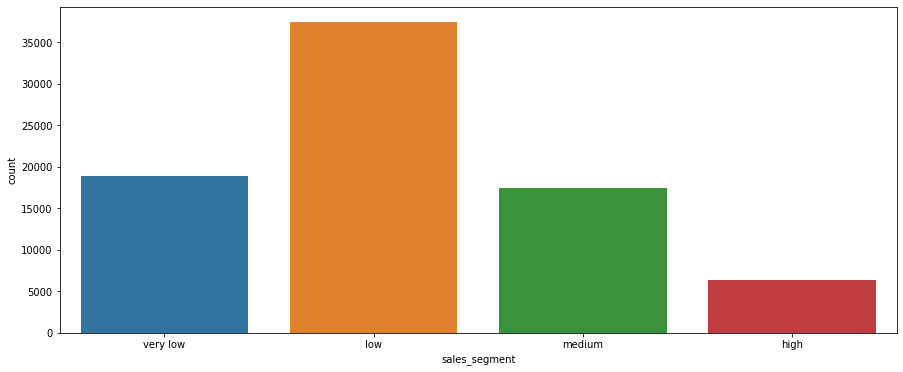

In [ ]:
plt.figure(figsize=(15,6));
sns.countplot(x='sales_segment', order=['very low','low', 'medium','high'], data=df_sales_segment)

#### The biggest segment in terms of number of customers is the 'low' sales segment with almost 36,000 customers belonging to this segment. 'very low' and medium' segment have close to 20,000 customers and the 'high' sales segment the lowest with around 5000 customers

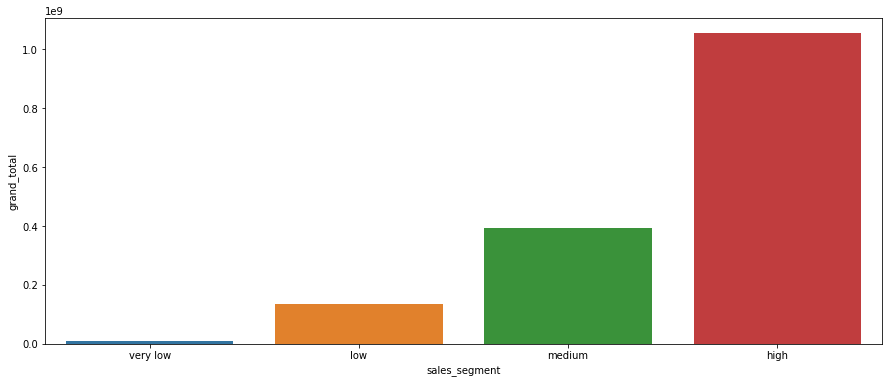

In [ ]:
plt.figure(figsize=(15,6));
sns.barplot(x='sales_segment', y='grand_total' ,order=['very low','low', 'medium', 'high'], data=sales_segment_total)

#### Highest sales revenue generated by the 'high' segment, followed by 'medium' sales segment. Least sales revenue is generated by the 'very low' segment, despite close to 20,000 customers belonging to this segment

#### Exploring each segment to check
- which items are purchased most by each segment?
- how many customers purchase more than one item during a single transaction?
- how many customers return to the store for doing more transactions?

### Very Low Sales segment

In [ ]:
df_vlow = df_sales_segment.loc[df_sales_segment['grand_total'] < 1900, ['Customer ID','grand_total']]
df_vlow

,Customer ID,grand_total
4,6,170.00
5,7,105.00
7,10,732.00
8,11,1095.00
20,30,885.00
...,...,...
80116,115317,1149.00
80117,115318,1888.75
80118,115320,849.00
80120,115324,549.00


In [ ]:
df_vlow_segment = df_vlow.merge(df, how='inner', on='Customer ID')
df_vlow_segment = df_vlow_segment[['Customer ID','created_at','category_name','payment_method','grand_total_y']]
df_vlow_segment

,Customer ID,created_at,category_name,payment_method,grand_total_y
0,6,2016-07-01,Soghaat,cod,170.00
1,7,2016-07-01,Beauty & Grooming,cod,60.00
2,7,2017-04-15,Men's Fashion,cod,15.00
3,7,2017-04-15,Home & Living,cod,15.00
4,7,2017-04-15,Mobiles & Tablets,cod,15.00
...,...,...,...,...,...
40292,115318,2018-08-28,Beauty & Grooming,cod,1888.75
40293,115320,2018-08-28,Women's Fashion,cod,849.00
40294,115324,2018-08-28,Men's Fashion,cod,549.00
40295,115325,2018-08-28,Women's Fashion,cod,550.00


In [ ]:
vlow_sales_segment_total = df_vlow_segment.groupby('category_name')['grand_total_y'].sum().reset_index()
vlow_sales_segment_total = vlow_sales_segment_total.sort_values(['grand_total_y'], ascending=False).reset_index(drop=True)
vlow_sales_segment_total

,category_name,grand_total_y
0,Men's Fashion,7.797560e+06
1,Mobiles & Tablets,4.142626e+06
2,Women's Fashion,3.005127e+06
3,Beauty & Grooming,2.044206e+06
4,Appliances,1.690798e+06
5,Health & Sports,1.316031e+06
6,Home & Living,1.255777e+06
7,Soghaat,8.953425e+05
8,Computing,7.893387e+05
9,Kids & Baby,7.883089e+05


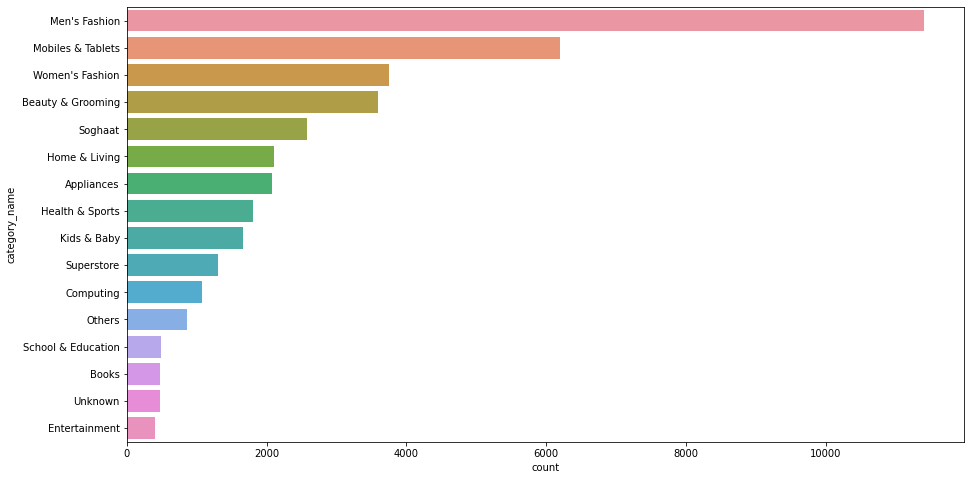

In [ ]:
plt.figure(figsize=(15,8));
sns.countplot(y='category_name', data=df_vlow_segment, order = df_vlow_segment['category_name'].value_counts().index)
plt.show()

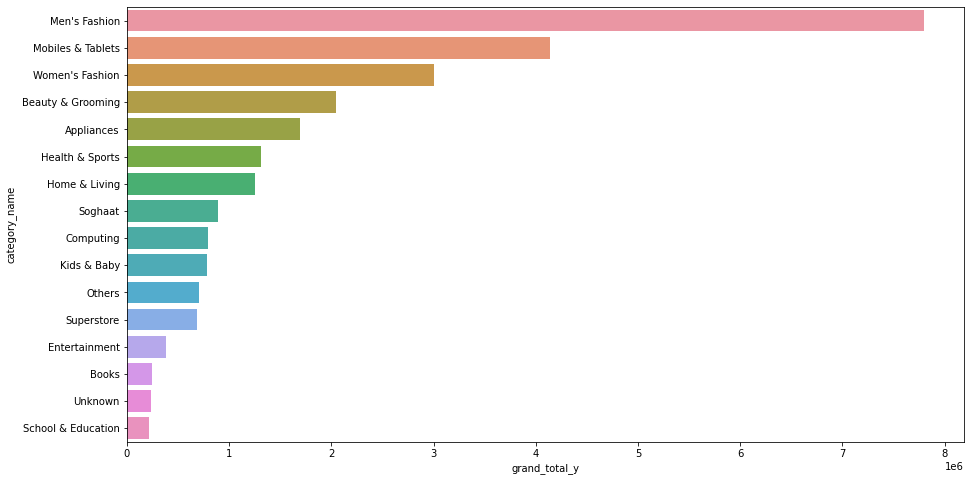

In [ ]:
plt.figure(figsize=(15,8));
sns.barplot(y='category_name', data=vlow_sales_segment_total, x='grand_total_y', order = vlow_sales_segment_total['category_name'])
plt.show()

#### The product category with the highest sales is "Men's Fashion" followed by "Mobiles & Tablets" and "Beauty & Grooming"

In [ ]:
vlow_sales_segment_datewise = df_vlow_segment.groupby('created_at')['grand_total_y'].sum().reset_index()
vlow_sales_segment_datewise

,created_at,grand_total_y
0,2016-07-01,17570.00
1,2016-07-02,13323.00
2,2016-07-03,12515.00
3,2016-07-04,12898.25
4,2016-07-05,7255.00
...,...,...
783,2018-08-24,14546.00
784,2018-08-25,20123.00
785,2018-08-26,23423.70
786,2018-08-27,22122.70


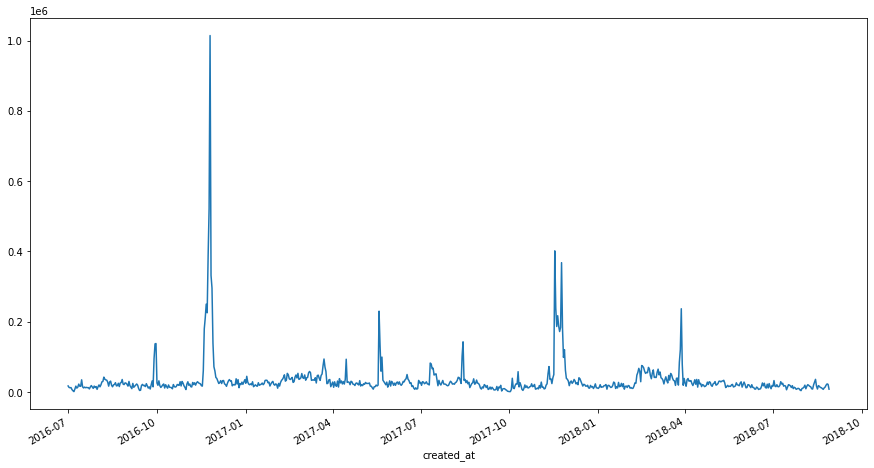

In [ ]:
vlow_sales_segment_datewise.set_index('created_at')['grand_total_y'].plot(figsize=(15,8))

#### Biggest spike of Rs 0.5M seen on Black Friday sales in 2016. Smaller spikes seen around the annual deals offered on 'Black Friday' 2017 and around the holiday period of Eid-ul-Fitr

In [ ]:
vlow_sales_segment_payment = df_vlow_segment.groupby('payment_method')['grand_total_y'].sum().reset_index()
vlow_sales_segment_payment = vlow_sales_segment_payment.sort_values(['grand_total_y'], ascending=False).reset_index(drop=True)
vlow_sales_segment_payment

,payment_method,grand_total_y
0,cod,2.290055e+07
1,Easypay,9.828369e+05
2,Payaxis,8.254649e+05
3,jazzwallet,7.450175e+05
4,bankalfalah,2.576900e+05
5,easypay_voucher,2.253387e+05
6,jazzvoucher,2.209637e+05
7,Others,5.422387e+04
8,customercredit,1.670000e+02


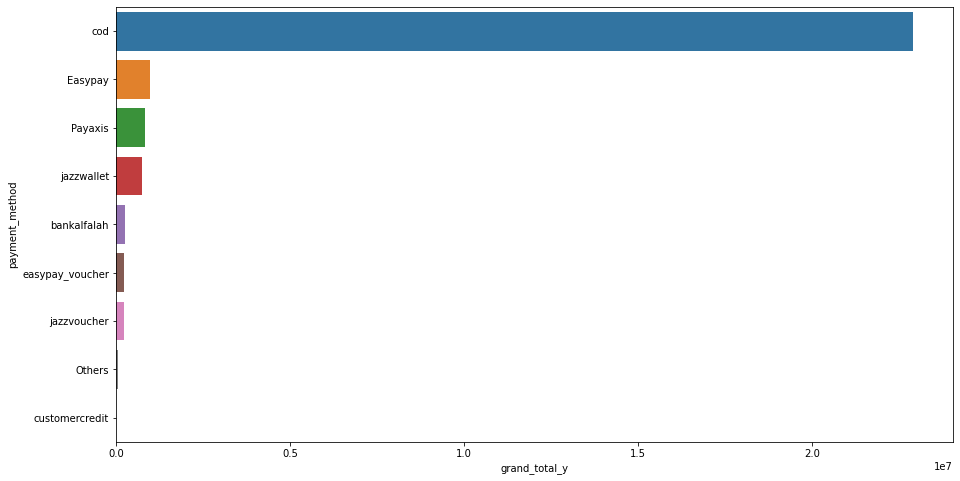

In [ ]:
plt.figure(figsize=(15,8));
sns.barplot(y='payment_method', data=vlow_sales_segment_payment, x='grand_total_y')
plt.show()

#### 'cod' or Cash on Delivery is the preferred payment method for this segment. Other payment methods have a very small contribution towards the total revenue.

In [ ]:
df_vlow_transactions = df_vlow_segment.groupby(['Customer ID','created_at']).size().reset_index(name='count')
df_vlow_transactions

,Customer ID,created_at,count
0,6,2016-07-01,1
1,7,2016-07-01,1
2,7,2017-04-15,3
3,10,2016-07-01,2
4,11,2016-07-01,1
...,...,...,...
33815,115317,2018-08-28,1
33816,115318,2018-08-28,1
33817,115320,2018-08-28,1
33818,115324,2018-08-28,1


In [ ]:
vlow_customer_count = df_vlow_transactions.loc[df_vlow_transactions['count'] > 1, :]
vlow_customer_count

,Customer ID,created_at,count
2,7,2017-04-15,3
3,10,2016-07-01,2
13,60,2016-07-01,8
21,83,2017-01-02,5
31,145,2016-07-01,5
...,...,...,...
33779,115230,2018-08-26,2
33784,115239,2018-08-26,2
33793,115269,2018-08-27,2
33797,115276,2018-08-27,2


In [ ]:
df_vlow_returning_customers = df_vlow_transactions.groupby('Customer ID')['created_at'].count().reset_index()
df_vlow_returning_customers

,Customer ID,created_at
0,6,1
1,7,2
2,10,1
3,11,4
4,30,2
...,...,...
30216,115317,1
30217,115318,1
30218,115320,1
30219,115324,1


In [ ]:
vlow_customer_returning = df_vlow_returning_customers.loc[df_vlow_returning_customers['created_at'] > 1, :]
vlow_customer_returning

,Customer ID,created_at
1,7,2
3,11,4
4,30,2
6,37,2
9,68,2
...,...,...
29909,114132,2
29938,114215,2
29939,114220,2
29950,114287,2


#### Out of 18,265 customers, only 1145 (6%) were returning customers and made more than one purchase on the E-commerce platform

### Low Sales segment

In [ ]:
df_low = df_sales_segment.loc[(df_sales_segment['grand_total'] > 1900) & (df_sales_segment['grand_total'] < 5750), ['Customer ID','grand_total']]
df_low

,Customer ID,grand_total
1,1,1950.0
2,3,4980.0
6,9,5500.0
9,12,3783.0
13,19,5526.0
...,...,...
80100,115293,2311.0
80103,115298,3249.0
80111,115308,5250.0
80112,115309,3700.0


In [ ]:
df_low_segment = df_low.merge(df, how='inner', on='Customer ID')
df_low_segment = df_low_segment[['Customer ID','created_at','category_name','payment_method','grand_total_y']]
df_low_segment

,Customer ID,created_at,category_name,payment_method,grand_total_y
0,1,2016-07-01,Women's Fashion,cod,1950.0
1,3,2017-05-19,Men's Fashion,cod,1245.0
2,3,2017-05-19,Men's Fashion,cod,1245.0
3,3,2017-05-19,Mobiles & Tablets,cod,1245.0
4,3,2017-05-19,Mobiles & Tablets,cod,1245.0
...,...,...,...,...,...
42116,115308,2018-08-27,Mobiles & Tablets,cod,5250.0
42117,115309,2018-08-28,Health & Sports,cod,1850.0
42118,115309,2018-08-28,Health & Sports,cod,1850.0
42119,115312,2018-08-28,Men's Fashion,cod,1999.0


In [ ]:
low_sales_segment_total = df_low_segment.groupby('category_name')['grand_total_y'].sum().reset_index()
low_sales_segment_total = low_sales_segment_total.sort_values(['grand_total_y'], ascending=False).reset_index(drop=True)
low_sales_segment_total

,category_name,grand_total_y
0,Men's Fashion,1.238488e+07
1,Women's Fashion,8.457865e+06
2,Others,7.604147e+06
3,Mobiles & Tablets,6.694493e+06
4,Appliances,6.066775e+06
5,Beauty & Grooming,5.568232e+06
6,Home & Living,2.869306e+06
7,Health & Sports,2.529610e+06
8,Computing,2.299969e+06
9,Entertainment,1.932738e+06


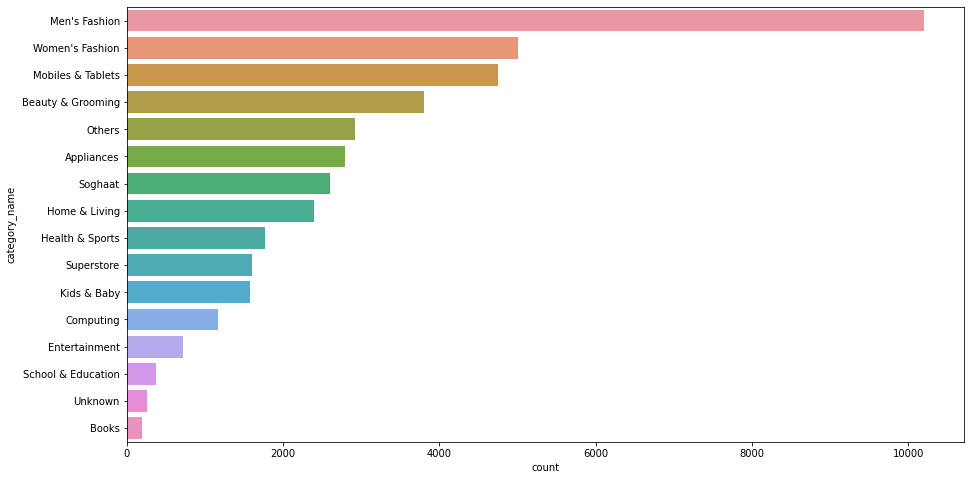

In [ ]:
plt.figure(figsize=(15,8));
sns.countplot(y='category_name', data=df_low_segment, order = df_low_segment['category_name'].value_counts().index)
plt.show()

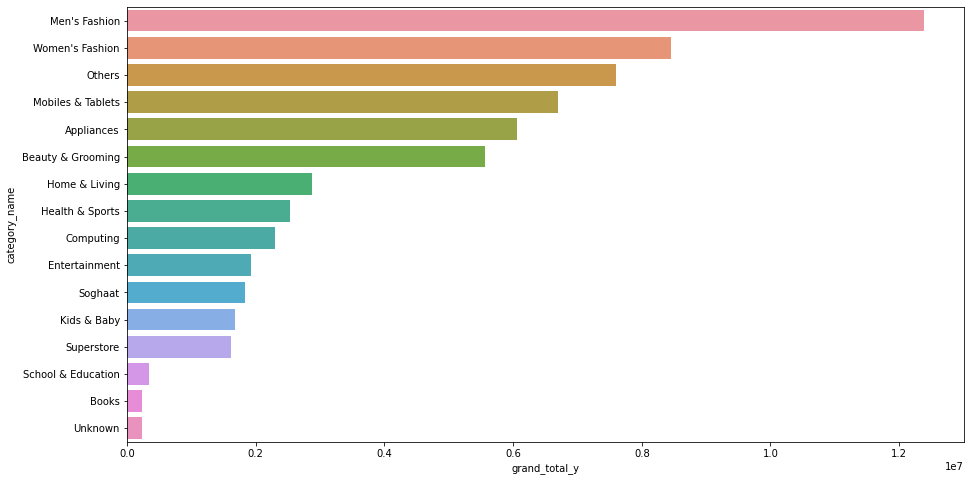

In [ ]:
plt.figure(figsize=(15,8));
sns.barplot(y='category_name', data=low_sales_segment_total, x='grand_total_y', order = low_sales_segment_total['category_name'])
plt.show()

#### The product category with the highest revenue from sales is "Men's Fashion" followed by "Women's Fashion" and "Mobiles & Tablets"

In [ ]:
low_sales_segment_datewise = df_low_segment.groupby('created_at')['grand_total_y'].sum().reset_index()
low_sales_segment_datewise

,created_at,grand_total_y
0,2016-07-01,62109.0
1,2016-07-02,16728.0
2,2016-07-03,24558.0
3,2016-07-04,13810.0
4,2016-07-05,11006.5
...,...,...
782,2018-08-24,21053.0
783,2018-08-25,44940.5
784,2018-08-26,27231.0
785,2018-08-27,56514.0


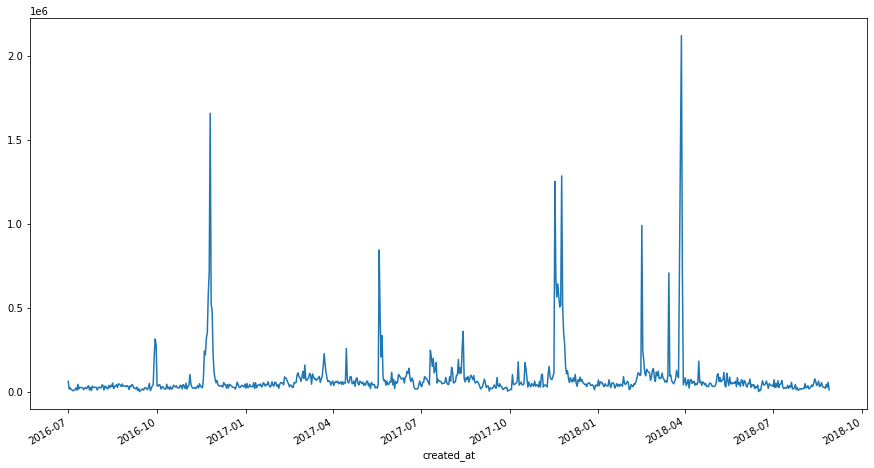

In [ ]:
low_sales_segment_datewise.set_index('created_at')['grand_total_y'].plot(figsize=(15,8))

#### Big spikes of greater than Rs 3.0M spending seen on 'Black Friday' period in both 2016 and 2017. Also a spike of Rs 3.0M seen in the period of Feb-Mar 2018 that corresponds to some annual deals

In [ ]:
low_sales_segment_payment = df_low_segment.groupby('payment_method')['grand_total_y'].sum().reset_index()
low_sales_segment_payment = low_sales_segment_payment.sort_values(['grand_total_y'], ascending=False).reset_index(drop=True)
low_sales_segment_payment

,payment_method,grand_total_y
0,cod,4.475678e+07
1,Easypay,7.101413e+06
2,Payaxis,4.011452e+06
3,easypay_voucher,2.244925e+06
4,jazzwallet,2.075375e+06
5,bankalfalah,1.311733e+06
6,jazzvoucher,6.125356e+05
7,Others,2.481315e+05
8,customercredit,1.534800e+02


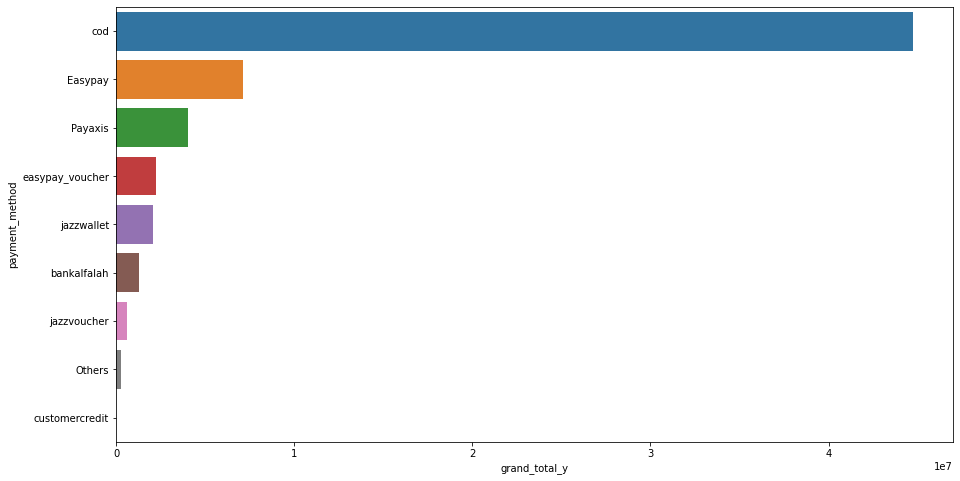

In [ ]:
plt.figure(figsize=(15,8));
sns.barplot(y='payment_method', data=low_sales_segment_payment, x='grand_total_y')
plt.show()

#### 'cod' or Cash on Delivery is the most used method by customers belonging to this segment and almost 100M revenue out of total 136M is generated through this payment method.

In [ ]:
df_low_transactions = df_low_segment.groupby(['Customer ID','created_at']).size().reset_index(name='count')
df_low_transactions

,Customer ID,created_at,count
0,1,2016-07-01,1
1,3,2017-05-19,4
2,9,2016-07-01,1
3,12,2016-07-01,1
4,12,2016-11-19,2
...,...,...,...
26125,115293,2018-08-27,1
26126,115298,2018-08-27,1
26127,115308,2018-08-27,1
26128,115309,2018-08-28,2


In [ ]:
low_customer_count = df_low_transactions.loc[df_low_transactions['count'] > 1, :]
low_customer_count

,Customer ID,created_at,count
1,3,2017-05-19,4
4,12,2016-11-19,2
6,19,2016-08-13,2
9,19,2016-09-05,2
13,22,2016-07-01,8
...,...,...,...
26119,115266,2018-08-27,2
26120,115267,2018-08-27,3
26121,115270,2018-08-27,2
26128,115309,2018-08-28,2


In [ ]:
df_low_returning_customers = df_low_transactions.groupby('Customer ID')['created_at'].count().reset_index()
df_low_returning_customers

,Customer ID,created_at
0,1,1
1,3,1
2,9,1
3,12,2
4,19,8
...,...,...
18471,115293,1
18472,115298,1
18473,115308,1
18474,115309,1


In [ ]:
low_customer_returning = df_low_returning_customers.loc[df_low_returning_customers['created_at'] > 1, :]
low_customer_returning

,Customer ID,created_at
3,12,2
4,19,8
7,34,2
8,40,2
10,46,2
...,...,...
18333,114370,2
18355,114526,2
18369,114728,2
18372,114748,3


#### Out of 37,105 customers in this segment, 9,167 (25%) were returning customers and made more than one purchase on the E-commerce store

### Medium Sales segment

In [ ]:
df_medium = df_sales_segment.loc[(df_sales_segment['grand_total'] > 5750) & (df_sales_segment['grand_total'] < 23000), ['Customer ID','grand_total']]
df_medium

,Customer ID,grand_total
0,0,16000.0
36,48,8738.0
38,52,14987.0
39,53,18000.0
49,63,21050.0
...,...,...
80088,115280,8185.0
80092,115284,6750.0
80102,115297,6745.0
80108,115303,12795.0


In [ ]:
df_medium_segment = df_medium.merge(df, how='inner', on='Customer ID')
df_medium_segment = df_medium_segment[['Customer ID','created_at','category_name','payment_method','grand_total_y']]
df_medium_segment

,Customer ID,created_at,category_name,payment_method,grand_total_y
0,0,2018-03-15,Others,Payaxis,16000.0
1,48,2016-07-01,Appliances,cod,1230.0
2,48,2016-07-03,Beauty & Grooming,cod,320.0
3,48,2016-07-03,Beauty & Grooming,cod,143.0
4,48,2016-09-09,Men's Fashion,cod,615.0
...,...,...,...,...,...
66630,115303,2018-08-27,Men's Fashion,cod,2559.0
66631,115303,2018-08-27,Men's Fashion,cod,2559.0
66632,115303,2018-08-27,Men's Fashion,cod,2559.0
66633,115303,2018-08-27,Men's Fashion,cod,2559.0


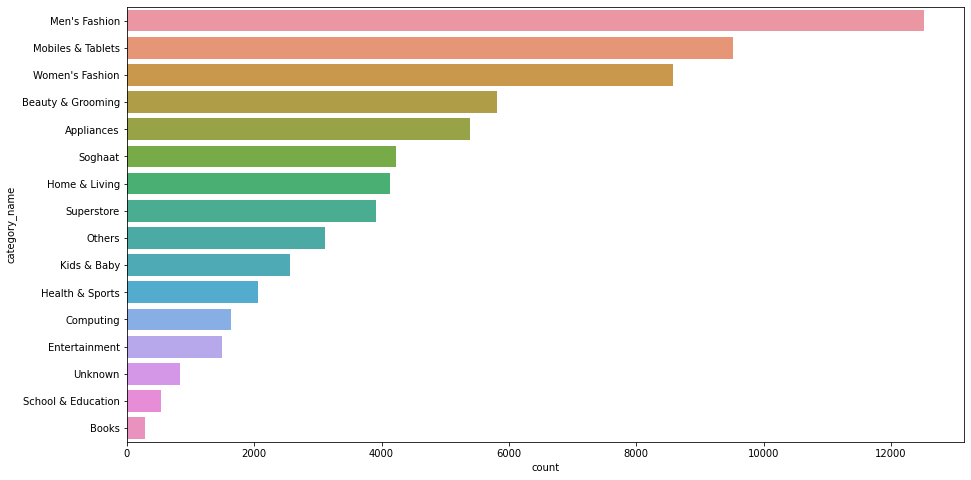

In [ ]:
plt.figure(figsize=(15,8));
sns.countplot(y='category_name', data=df_medium_segment, order = df_medium_segment['category_name'].value_counts().index)
plt.show()

In [ ]:
medium_sales_segment_total = df_medium_segment.groupby('category_name')['grand_total_y'].sum().reset_index()
medium_sales_segment_total = medium_sales_segment_total.sort_values(['grand_total_y'], ascending=False).reset_index(drop=True)
medium_sales_segment_total

,category_name,grand_total_y
0,Mobiles & Tablets,6.360551e+07
1,Women's Fashion,2.488894e+07
2,Appliances,2.460877e+07
3,Men's Fashion,2.230499e+07
4,Others,1.879027e+07
5,Entertainment,1.520500e+07
6,Beauty & Grooming,1.061784e+07
7,Home & Living,7.554642e+06
8,Unknown,7.135632e+06
9,Superstore,5.924738e+06


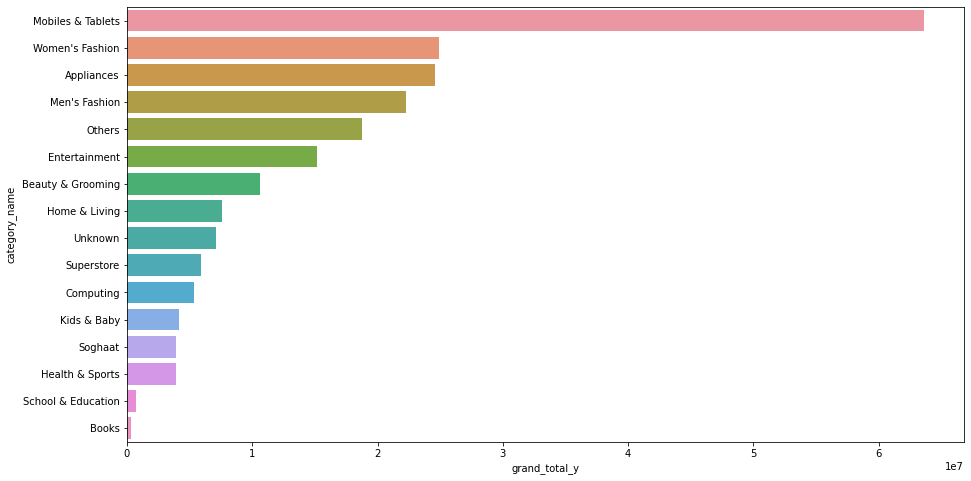

In [ ]:
plt.figure(figsize=(15,8));
sns.barplot(y='category_name', data=medium_sales_segment_total, x='grand_total_y', order = medium_sales_segment_total['category_name'])
plt.show()

#### Mobiles & Tablets generate the highest amount of revenue for the 'medium' sales segment of customers, which is about 3 times higher than the 2nd best category 'Appliances'

In [ ]:
medium_sales_segment_datewise = df_medium_segment.groupby('created_at')['grand_total_y'].sum().reset_index()
medium_sales_segment_datewise

,created_at,grand_total_y
0,2016-07-01,58613.00
1,2016-07-02,31118.00
2,2016-07-03,29666.00
3,2016-07-04,54850.00
4,2016-07-05,53841.00
...,...,...
781,2018-08-24,76036.00
782,2018-08-25,66751.50
783,2018-08-26,97821.20
784,2018-08-27,92875.25


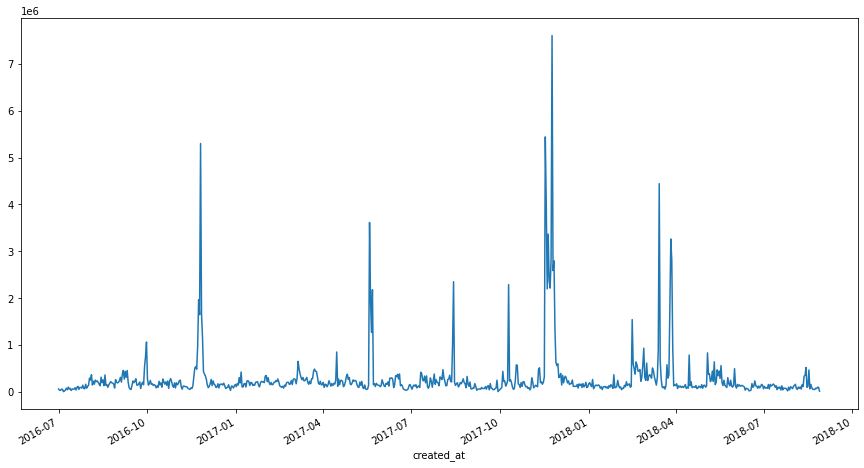

In [ ]:
medium_sales_segment_datewise.set_index('created_at')['grand_total_y'].plot(figsize=(15,8))

#### Customers belonging to this segment were very active on annual Black Friday in November 2017. Another active period was Mar-Apr 2018 and significant activity on Black Friday 2016 and Eid-ul-Fitr 2017.

In [ ]:
medium_sales_segment_payment = df_medium_segment.groupby('payment_method')['grand_total_y'].sum().reset_index()
medium_sales_segment_payment = medium_sales_segment_payment.sort_values(['grand_total_y'], ascending=False).reset_index(drop=True)
medium_sales_segment_payment

,payment_method,grand_total_y
0,cod,1.268827e+08
1,Easypay,3.205198e+07
2,Payaxis,2.903912e+07
3,easypay_voucher,1.365918e+07
4,jazzwallet,6.484128e+06
5,bankalfalah,6.181865e+06
6,jazzvoucher,3.562098e+06
7,Others,1.244278e+06
8,customercredit,5.100000e+01


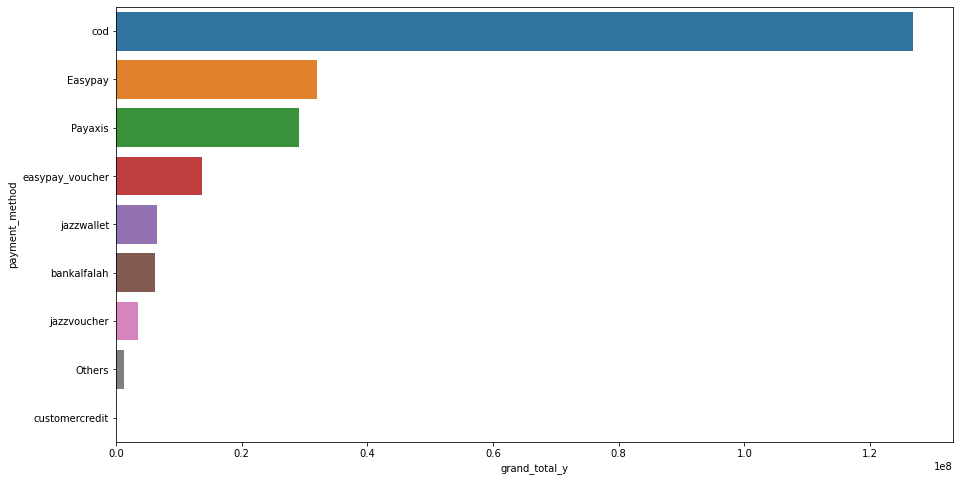

In [ ]:
plt.figure(figsize=(15,8));
sns.barplot(y='payment_method', data=medium_sales_segment_payment, x='grand_total_y')
plt.show()

#### Out of 394M, almost 175M is collected through 'cod' or Cash on Delivery payment method but other payment methods have a better share for this segment than 'very low' and 'low' sales segments

In [ ]:
df_medium_transactions = df_medium_segment.groupby(['Customer ID','created_at']).size().reset_index(name='count')
df_medium_transactions

,Customer ID,created_at,count
0,0,2018-03-15,1
1,48,2016-07-01,1
2,48,2016-07-03,2
3,48,2016-09-09,2
4,48,2017-04-17,2
...,...,...,...
33512,115280,2018-08-27,5
33513,115284,2018-08-27,1
33514,115297,2018-08-27,1
33515,115303,2018-08-27,5


In [ ]:
medium_customer_count = df_medium_transactions.loc[df_medium_transactions['count'] > 1, :]
medium_customer_count

,Customer ID,created_at,count
2,48,2016-07-03,2
3,48,2016-09-09,2
4,48,2017-04-17,2
5,48,2017-06-02,3
6,52,2016-07-02,2
...,...,...,...
33505,115198,2018-08-25,2
33506,115221,2018-08-26,3
33508,115242,2018-08-26,2
33512,115280,2018-08-27,5


In [ ]:
df_medium_returning_customers = df_medium_transactions.groupby('Customer ID')['created_at'].count().reset_index()
df_medium_returning_customers

,Customer ID,created_at
0,0,1
1,48,5
2,52,3
3,53,2
4,63,14
...,...,...
18027,115280,1
18028,115284,1
18029,115297,1
18030,115303,1


In [ ]:
medium_customer_returning = df_medium_returning_customers.loc[df_medium_returning_customers['created_at'] > 1, :]
medium_customer_returning

,Customer ID,created_at
1,48,5
2,52,3
3,53,2
4,63,14
5,70,9
...,...,...
17921,114565,4
17955,114745,2
17996,114973,3
18004,115028,2


#### In the 'medium' sales segment, out of 83,389 transactions made by 17,385 customers, 7,278 or 42% of the customers made more than one purchase or were returning customers

### High Sales segment

In [ ]:
df_high = df_sales_segment.loc[df_sales_segment['grand_total'] > 23000, ['Customer ID','grand_total']]
df_high

,Customer ID,grand_total
3,4,1316173.25
10,13,410495.80
11,15,87846.93
12,16,100032.33
14,20,1820608.65
...,...,...
80065,115253,142080.00
80066,115256,29554.00
80107,115302,36270.00
80109,115304,157955.00


In [ ]:
df_high_segment = df_high.merge(df, how='inner', on='Customer ID')
df_high_segment = df_high_segment[['Customer ID','created_at','category_name','payment_method','grand_total_y']]
df_high_segment

,Customer ID,created_at,category_name,payment_method,grand_total_y
0,4,2016-07-01,Beauty & Grooming,cod,60.0
1,4,2016-07-04,Beauty & Grooming,cod,160.0
2,4,2016-07-13,Men's Fashion,cod,150.0
3,4,2016-07-15,Superstore,cod,1275.0
4,4,2016-07-19,Beauty & Grooming,cod,680.0
...,...,...,...,...,...
166309,115304,2018-08-27,Mobiles & Tablets,bankalfalah,31591.0
166310,115304,2018-08-27,Mobiles & Tablets,bankalfalah,31591.0
166311,115304,2018-08-27,Mobiles & Tablets,bankalfalah,31591.0
166312,115304,2018-08-27,Mobiles & Tablets,bankalfalah,31591.0


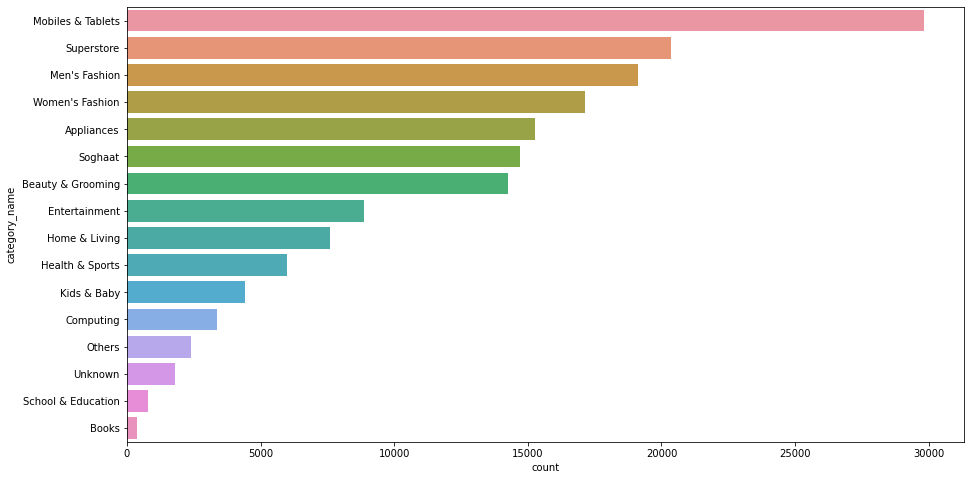

In [ ]:
plt.figure(figsize=(15,8));
sns.countplot(y='category_name', data=df_high_segment, order = df_high_segment['category_name'].value_counts().index)
plt.show()

#### Mobiles & Tablets is the category which has highest number of transactions for 'high' sales segment

In [ ]:
high_sales_segment_total = df_high_segment.groupby('category_name')['grand_total_y'].sum().reset_index()
high_sales_segment_total = high_sales_segment_total.sort_values(['grand_total_y'], ascending=False).reset_index(drop=True)
high_sales_segment_total

,category_name,grand_total_y
0,Mobiles & Tablets,5.028793e+08
1,Appliances,2.046925e+08
2,Entertainment,1.753442e+08
3,Women's Fashion,1.093761e+08
4,Superstore,5.244353e+07
5,Men's Fashion,4.651719e+07
6,Computing,4.064088e+07
7,Beauty & Grooming,3.184539e+07
8,Others,3.131941e+07
9,Home & Living,3.038132e+07


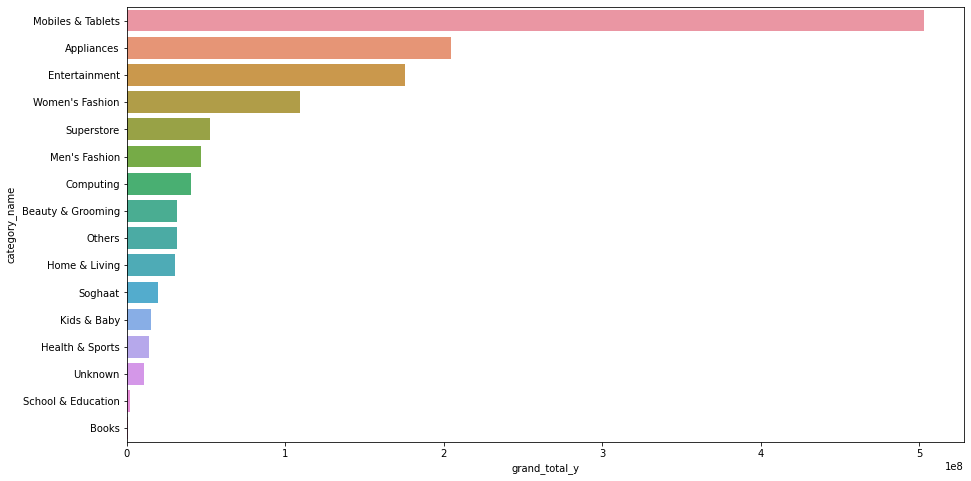

In [ ]:
plt.figure(figsize=(15,8));
sns.barplot(y='category_name', data=high_sales_segment_total, x='grand_total_y', order = high_sales_segment_total['category_name'])
plt.show()

#### 'Mobiles & Tablets' is the most favourite product category in terms of revenue generated by the 'high' sales segment group and almost 3 times more revenue is generated as compared to the next product category 'Appliances. The pattern is very much similar to the pattern seen in the 'medium' sales segment

In [ ]:
high_sales_segment_datewise = df_high_segment.groupby('created_at')['grand_total_y'].sum().reset_index()
high_sales_segment_datewise

,created_at,grand_total_y
0,2016-07-01,219893.00
1,2016-07-02,191063.00
2,2016-07-03,41674.00
3,2016-07-04,495116.00
4,2016-07-05,145172.00
...,...,...
782,2018-08-24,922680.10
783,2018-08-25,581526.20
784,2018-08-26,346246.50
785,2018-08-27,548545.97


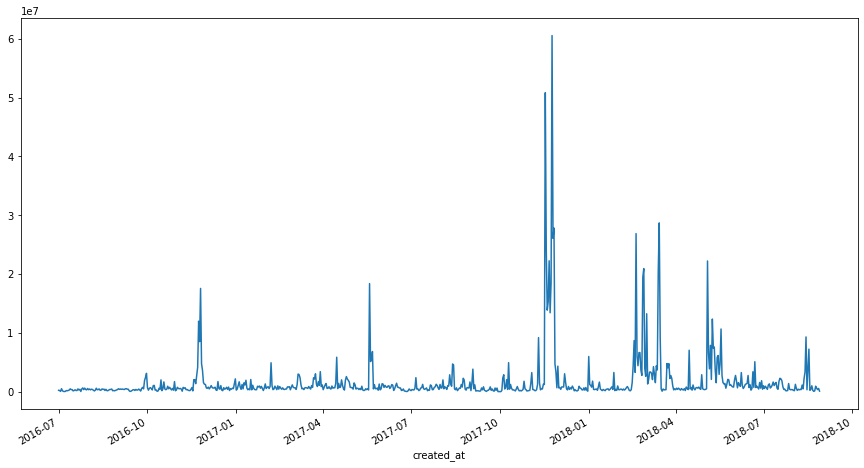

In [ ]:
high_sales_segment_datewise.set_index('created_at')['grand_total_y'].plot(figsize=(15,8))

#### Big spike of more than Rs 30M seen on annual Black Friday sales in 2017 with smaller spikes of greater than Rs 10M seen on other public holidays and annual sales

In [ ]:
high_sales_segment_payment = df_high_segment.groupby('payment_method')['grand_total_y'].sum().reset_index()
high_sales_segment_payment = high_sales_segment_payment.sort_values(['grand_total_y'], ascending=False).reset_index(drop=True)
high_sales_segment_payment

,payment_method,grand_total_y
0,cod,3.678772e+08
1,easypay_voucher,3.053109e+08
2,Payaxis,2.210435e+08
3,Easypay,2.042943e+08
4,bankalfalah,8.442548e+07
5,jazzvoucher,6.616840e+07
6,jazzwallet,3.069639e+07
7,Others,8.228225e+06
8,customercredit,4.900000e+01


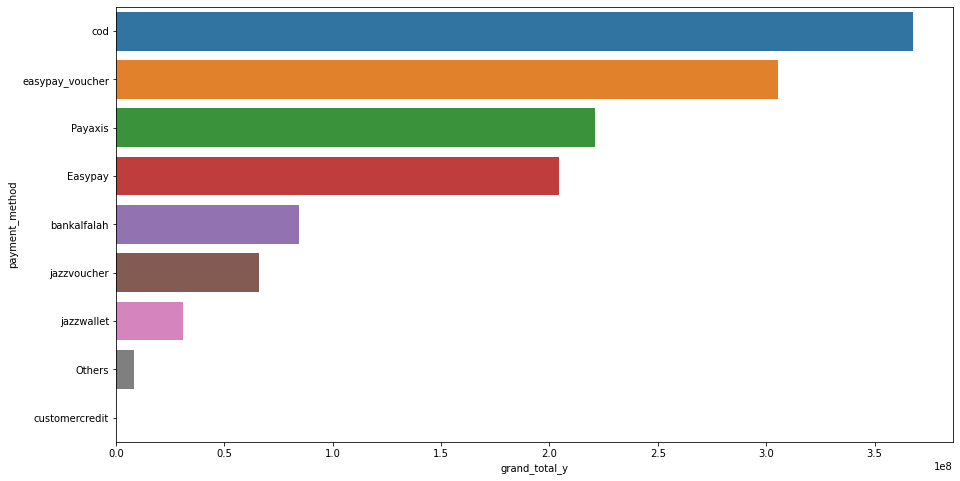

In [ ]:
plt.figure(figsize=(15,8));
sns.barplot(y='payment_method', data=high_sales_segment_payment, x='grand_total_y')
plt.show()

#### 'cod' or Cash on Delivery still contributes about 1/4th of the total revenue generated by this segment but other digital payment methods like Easypay_voucher, Payaxis, Easypay and bankalfalah have significant share in the overall revenue.

In [ ]:
df_high_transactions = df_high_segment.groupby(['Customer ID','created_at']).size().reset_index(name='count')
df_high_transactions

,Customer ID,created_at,count
0,4,2016-07-01,1
1,4,2016-07-04,1
2,4,2016-07-13,1
3,4,2016-07-15,1
4,4,2016-07-19,3
...,...,...,...
54330,115253,2018-08-27,8
54331,115256,2018-08-27,2
54332,115302,2018-08-27,9
54333,115304,2018-08-27,5


In [ ]:
high_customer_count = df_high_transactions.loc[df_high_transactions['count'] > 1, :]
high_customer_count

,Customer ID,created_at,count
4,4,2016-07-19,3
5,4,2016-07-28,2
8,4,2016-08-11,5
9,4,2016-08-12,2
10,4,2016-08-13,2
...,...,...,...
54327,115200,2018-08-25,3
54330,115253,2018-08-27,8
54331,115256,2018-08-27,2
54332,115302,2018-08-27,9


In [ ]:
df_high_returning_customers = df_high_transactions.groupby('Customer ID')['created_at'].count().reset_index()
df_high_returning_customers

,Customer ID,created_at
0,4,122
1,13,42
2,15,13
3,16,27
4,20,108
...,...,...
13313,115253,1
13314,115256,1
13315,115302,1
13316,115304,1


In [ ]:
high_customer_returning = df_high_returning_customers.loc[df_high_returning_customers['created_at'] > 1, :]
high_customer_returning

,Customer ID,created_at
0,4,122
1,13,42
2,15,13
3,16,27
4,20,108
...,...,...
13233,114549,2
13268,114711,3
13293,114928,2
13302,115038,2


#### In the 'high' sales segment, out of 125,096 transactions made by 6,431 customers, 4,368 or 68% of the customers made more than one purchase or were returning customers

## Summary

#### Very Low Sales segment
- Total customers: 18,265
- Total Revenue generated: Rs.10.7 Million
- 6% were returning customers on the E-commerce platform
- Average revenue generated per customer: Rs 590
- Top 3 revenue generating product categories are
    - Men's Fashion
    - Mobiles & Tablets
    - Beauty & Grooming

#### Low Sales segment
- Total customers: 37,105
- Total Revenue generated: Rs.136 Million
- 25% were returning customers on the E-commerce platform
- Average revenue generated per customer: Rs 3,747
- Top 3 revenue generating product categories are
    - Men's Fashion
    - Women's Fashion
    - Mobiles & Tablets

#### Medium  Sales segment
- Total customers: 17,385
- Total Revenue generated: Rs.394 Million
- 42% were returning customers on the E-commerce platform
- Average revenue generated per customer: Rs 22,713
- Top 3 revenue generating product categories are
    - Mobiles & Tablets
    - Appliances
    - Entertainment


#### High  Sales segment
- Total customers: 6,431
- Total Revenue generated: Rs.1,054 Million
- 68% were returning customers on the E-commerce platform
- Average revenue generated per customer: Rs 163,997. 
- Top 3 revenue generating product categories are
    - Mobiles & Tablets
    - Appliances
    - Entertainment

## Segmentation based on sales in different categories

In [ ]:
pivoted= pd.pivot_table(df,index='Customer ID',columns='category_name', values='grand_total',aggfunc='sum',fill_value=0)

In [ ]:
pivoted

category_name,Appliances,Beauty & Grooming,Books,Computing,Entertainment,Health & Sports,Home & Living,Kids & Baby,Men's Fashion,Mobiles & Tablets,Others,School & Education,Soghaat,Superstore,Unknown,Women's Fashion
Customer ID,,,,,,,,,,,,,,,,
0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16000.0,0.0,0.0,0.0,0.00,0.0
1,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,1950.0
3,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,2490.0,2490.0,0.0,0.0,0.0,0.0,0.00,0.0
4,75050.8,14310.40,0.0,99.0,225227.2,999.0,17331.0,1740.0,64134.0,715789.6,999.0,0.0,23040.0,82255.0,83020.75,12177.5
6,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,170.0,0.0,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115318,0.0,1888.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
115320,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,849.0
115323,44499.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0


In [ ]:
pivoted.dtypes

category_name
Appliances            float64
Beauty & Grooming     float64
Books                 float64
Computing             float64
Entertainment         float64
Health & Sports       float64
Home & Living         float64
Kids & Baby           float64
Men's Fashion         float64
Mobiles & Tablets     float64
Others                float64
School & Education    float64
Soghaat               float64
Superstore            float64
Unknown               float64
Women's Fashion       float64
dtype: object

In [ ]:
new = pivoted.reset_index()
new

category_name,Customer ID,Appliances,Beauty & Grooming,Books,Computing,Entertainment,Health & Sports,Home & Living,Kids & Baby,Men's Fashion,Mobiles & Tablets,Others,School & Education,Soghaat,Superstore,Unknown,Women's Fashion
0,0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16000.0,0.0,0.0,0.0,0.00,0.0
1,1,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,1950.0
2,3,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,2490.0,2490.0,0.0,0.0,0.0,0.0,0.00,0.0
3,4,75050.8,14310.40,0.0,99.0,225227.2,999.0,17331.0,1740.0,64134.0,715789.6,999.0,0.0,23040.0,82255.0,83020.75,12177.5
4,6,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,170.0,0.0,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80117,115318,0.0,1888.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
80118,115320,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,849.0
80119,115323,44499.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
80120,115324,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,549.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0


In [ ]:
X= new.drop('Customer ID',axis=1)
X.head()

category_name,Appliances,Beauty & Grooming,Books,Computing,Entertainment,Health & Sports,Home & Living,Kids & Baby,Men's Fashion,Mobiles & Tablets,Others,School & Education,Soghaat,Superstore,Unknown,Women's Fashion
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16000.0,0.0,0.0,0.0,0.00,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,1950.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2490.0,2490.0,0.0,0.0,0.0,0.0,0.00,0.0
3,75050.8,14310.4,0.0,99.0,225227.2,999.0,17331.0,1740.0,64134.0,715789.6,999.0,0.0,23040.0,82255.0,83020.75,12177.5
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,170.0,0.0,0.00,0.0


In [ ]:
from sklearn.cluster import KMeans
from sklearn import metrics 

In [ ]:
# generating random clutser with value set to 5
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(X)

KMeans(n_clusters=5, random_state=0)

In [ ]:
pred = X.copy()
pred['kmean1'] = kmeans.labels_
pred.head()

category_name,Appliances,Beauty & Grooming,Books,Computing,Entertainment,Health & Sports,Home & Living,Kids & Baby,Men's Fashion,Mobiles & Tablets,Others,School & Education,Soghaat,Superstore,Unknown,Women's Fashion,kmean1
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16000.0,0.0,0.0,0.0,0.00,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,1950.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2490.0,2490.0,0.0,0.0,0.0,0.0,0.00,0.0,0
3,75050.8,14310.4,0.0,99.0,225227.2,999.0,17331.0,1740.0,64134.0,715789.6,999.0,0.0,23040.0,82255.0,83020.75,12177.5,2
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,170.0,0.0,0.00,0.0,0


In [ ]:
col_names = X.columns
col_names

Index(['Appliances', 'Beauty & Grooming', 'Books', 'Computing',
       'Entertainment', 'Health & Sports', 'Home & Living', 'Kids & Baby',
       'Men's Fashion', 'Mobiles & Tablets', 'Others', 'School & Education',
       'Soghaat', 'Superstore', 'Unknown', 'Women's Fashion'],
      dtype='object', name='category_name')

##### Performing scaling for implementation of Kmeans

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()

In [ ]:
scaled = scaler.fit_transform(X)

In [ ]:
scaled=pd.DataFrame(columns=col_names,data=scaled)

In [ ]:
scaled.head()

category_name,Appliances,Beauty & Grooming,Books,Computing,Entertainment,Health & Sports,Home & Living,Kids & Baby,Men's Fashion,Mobiles & Tablets,Others,School & Education,Soghaat,Superstore,Unknown,Women's Fashion
0,0.000000,0.000000,0.0,0.000000,0.000090,0.000000,0.000000,0.000000,0.000000,0.000000,0.016667,0.01202,0.000000,0.000310,0.000000,0.000000
1,0.000000,0.000000,0.0,0.000000,0.000090,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.01202,0.000000,0.000310,0.000000,0.000432
2,0.000000,0.000000,0.0,0.000000,0.000090,0.000000,0.000000,0.000000,0.002379,0.000070,0.000000,0.01202,0.000000,0.000310,0.000000,0.000000
3,0.034181,0.011925,0.0,0.000103,0.140306,0.000307,0.011736,0.000943,0.061278,0.020008,0.001041,0.01202,0.032013,0.119065,0.091108,0.002698
4,0.000000,0.000000,0.0,0.000000,0.000090,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.01202,0.000236,0.000310,0.000000,0.000000


#### Choosing K for Kmeans

In [ ]:
cost = []
# run for cluster 1 to 15
for k in range(1, 15):
    kmeanModel = KMeans(n_clusters=k, random_state=0).fit(scaled)
    cost.append([k,kmeanModel.inertia_])

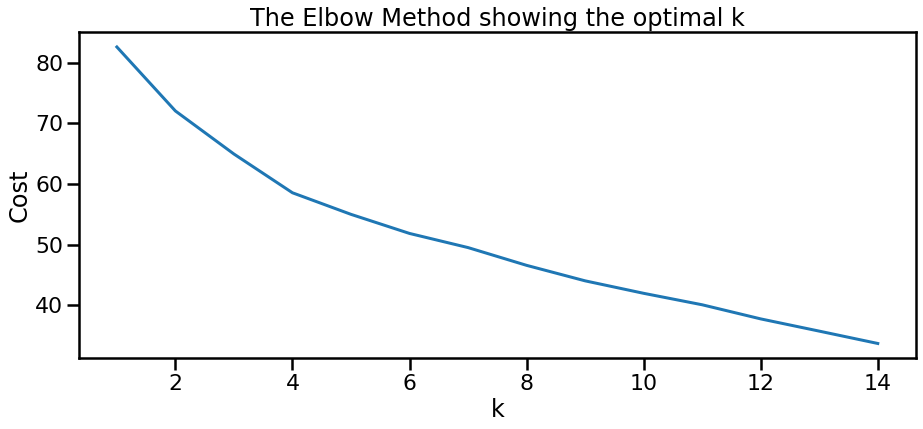

In [ ]:
plt.figure(figsize=(15,6))
sns.set_context('poster')
plt.plot(pd.DataFrame(cost)[0], pd.DataFrame(cost)[1])
plt.xlabel('k')
plt.ylabel('Cost')
plt.title('The Elbow Method showing the optimal k') 
plt.show()

##### The plot shows that optimal method for K is 4

In [ ]:
#pred = scaled.copy()

#Write code here
kmean4 = KMeans(n_clusters=4, random_state=0)

#write code to fit
kmean4.fit(scaled)

#Write code to assign labels to predicted data
pred['kmean4'] = kmean4.labels_

#View the final data set i.e top 5 rows
pred.head()

category_name,Appliances,Beauty & Grooming,Books,Computing,Entertainment,Health & Sports,Home & Living,Kids & Baby,Men's Fashion,Mobiles & Tablets,Others,School & Education,Soghaat,Superstore,Unknown,Women's Fashion,kmean1,kmean4
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16000.0,0.0,0.0,0.0,0.00,0.0,0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,1950.0,0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2490.0,2490.0,0.0,0.0,0.0,0.0,0.00,0.0,0,0
3,75050.8,14310.4,0.0,99.0,225227.2,999.0,17331.0,1740.0,64134.0,715789.6,999.0,0.0,23040.0,82255.0,83020.75,12177.5,2,2
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,170.0,0.0,0.00,0.0,0,0


In [ ]:
pred = pred.drop('kmean1',axis=1)
pred.head()

category_name,Appliances,Beauty & Grooming,Books,Computing,Entertainment,Health & Sports,Home & Living,Kids & Baby,Men's Fashion,Mobiles & Tablets,Others,School & Education,Soghaat,Superstore,Unknown,Women's Fashion,kmean4
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16000.0,0.0,0.0,0.0,0.00,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,1950.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2490.0,2490.0,0.0,0.0,0.0,0.0,0.00,0.0,0
3,75050.8,14310.4,0.0,99.0,225227.2,999.0,17331.0,1740.0,64134.0,715789.6,999.0,0.0,23040.0,82255.0,83020.75,12177.5,2
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,170.0,0.0,0.00,0.0,0


In [ ]:
pivoted = pred.groupby('kmean4')["Appliances", "Beauty & Grooming","Books","Computing","Entertainment", "Health & Sports", "Home & Living","Kids & Baby","Men's Fashion","Mobiles & Tablets","Others","School & Education","Soghaat","Superstore","Unknown","Women's Fashion"].sum().reset_index()
pivoted

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


category_name,kmean4,Appliances,Beauty & Grooming,Books,Computing,Entertainment,Health & Sports,Home & Living,Kids & Baby,Men's Fashion,Mobiles & Tablets,Others,School & Education,Soghaat,Superstore,Unknown,Women's Fashion
0,0,1.630112e+08,4.238964e+07,1533771.17,2.960762e+07,1.095686e+08,1.977989e+07,3.640341e+07,1.842882e+07,8.008916e+07,5.569988e+08,5.785517e+07,3.143277e+06,2.201411e+07,3.420803e+07,1.479851e+07,1.359200e+08
1,1,2.490984e+06,3.239494e+05,5062.00,1.702031e+07,1.150414e+06,1.749770e+05,6.038875e+05,1.037320e+05,3.931078e+05,2.985539e+06,1.580540e+05,0.000000e+00,6.762400e+04,5.036000e+03,3.391690e+05,4.372230e+05
2,2,6.511355e+07,3.064786e+06,23735.00,1.558275e+06,7.747179e+07,4.862179e+05,4.280611e+06,2.608156e+06,6.258674e+06,4.351146e+07,4.724962e+05,3.762393e+04,1.510405e+06,1.338622e+06,2.595410e+06,6.947170e+06
3,3,6.469886e+06,4.353645e+06,58923.57,9.053867e+05,4.688997e+06,1.140833e+06,7.750286e+05,6.225783e+05,2.275428e+06,9.653226e+06,3.081858e+05,1.011442e+05,2.905945e+06,2.511962e+07,9.855072e+05,2.468576e+06


In [ ]:
pivoted['Name'] = ''
pivoted.loc[pivoted['kmean4'] == 0, 'Name'] = 'Cluster 0'
pivoted.loc[pivoted['kmean4'] == 1, 'Name'] = 'Cluster 1'
pivoted.loc[pivoted['kmean4'] == 2, 'Name'] = 'Cluster 2'
pivoted.loc[pivoted['kmean4'] == 3, 'Name'] = 'Cluster 3'

In [ ]:
import re
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

In [ ]:
plt_cols = ["Appliances", "Beauty & Grooming","Books","Computing","Entertainment", "Health & Sports", "Home & Living","Kids & Baby","Men's Fashion","Mobiles & Tablets","Others","School & Education","Soghaat","Superstore","Unknown","Women's Fashion","Appliances"]
#top_fwds.reset_index(inplace=True)

plt_data = [] 
for i in range(0,1):
    trace = go.Scatterpolar(
        r = pivoted.loc[i,plt_cols],
        theta = plt_cols,
        #mode = 'lines',
        name = pivoted.loc[i,'Name'],
    )
    plt_data.append(trace)
    
layout = go.Layout(
  polar = dict(
    radialaxis = dict(
      visible = True,
      range = [0, 550000000],
    )
  ),
    height = 900,
    width = 900,
    title = "Segments based on Category Name",
    showlegend = True
)

fig = go.Figure(data=plt_data, layout=layout)
iplot(fig)

In [ ]:
plt_cols = ["Appliances", "Beauty & Grooming","Books","Computing","Entertainment", "Health & Sports", "Home & Living","Kids & Baby","Men's Fashion","Mobiles & Tablets","Others","School & Education","Soghaat","Superstore","Unknown","Women's Fashion","Appliances"]
#top_fwds.reset_index(inplace=True)

plt_data = [] 
for i in range(1,2):
    trace = go.Scatterpolar(
        r = pivoted.loc[i,plt_cols],
        theta = plt_cols,
        #mode = 'lines',
        name = pivoted.loc[i,'Name'],
    )
    plt_data.append(trace)
    
layout = go.Layout(
  polar = dict(
    radialaxis = dict(
      visible = True,
      range = [0, 20000000],
    )
  ),
    height = 900,
    width = 900,
    title = "Segments based on Category Name",
    showlegend = True
)

fig = go.Figure(data=plt_data, layout=layout)
iplot(fig)

In [ ]:
plt_cols = ["Appliances", "Beauty & Grooming","Books","Computing","Entertainment", "Health & Sports", "Home & Living","Kids & Baby","Men's Fashion","Mobiles & Tablets","Others","School & Education","Soghaat","Superstore","Unknown","Women's Fashion","Appliances"]
#top_fwds.reset_index(inplace=True)

plt_data = [] 
for i in range(2,3):
    trace = go.Scatterpolar(
        r = pivoted.loc[i,plt_cols],
        theta = plt_cols,
        #mode = 'lines',
        name = pivoted.loc[i,'Name'],
    )
    plt_data.append(trace)
    
layout = go.Layout(
  polar = dict(
    radialaxis = dict(
      visible = True,
      range = [0, 80000000],
    )
  ),
    height = 900,
    width = 900,
    title = "Segments based on Category Name",
    showlegend = True
)

fig = go.Figure(data=plt_data, layout=layout)
iplot(fig)

In [ ]:
plt_cols = ["Appliances", "Beauty & Grooming","Books","Computing","Entertainment", "Health & Sports", "Home & Living","Kids & Baby","Men's Fashion","Mobiles & Tablets","Others","School & Education","Soghaat","Superstore","Unknown","Women's Fashion","Appliances"]
#top_fwds.reset_index(inplace=True)

plt_data = [] 
for i in range(3,4):
    trace = go.Scatterpolar(
        r = pivoted.loc[i,plt_cols],
        theta = plt_cols,
        #mode = 'lines',
        name = pivoted.loc[i,'Name'],
    )
    plt_data.append(trace)
    
layout = go.Layout(
  polar = dict(
    radialaxis = dict(
      visible = True,
      range = [0, 25000000],
    )
  ),
    height = 900,
    width = 900,
    title = "Segments based on Category Name",
    showlegend = True
)

fig = go.Figure(data=plt_data, layout=layout)
iplot(fig)

## Summary
The clustering algorithm focuses on segmentation based on spending within a particular product category and hence the results are a bit different from the overall spending. However, it gives a different insight into the spending patterns of customer segement witin the dataset.